In [1]:
import numpy as np
import matplotlib.pyplot as plt

import product_fem as pf
import fenics
import inference
rng = np.random.default_rng()

In [2]:
nx, ny = 6, 4 # mesh resolution
max_xy = (1.5, 1)
mesh = fenics.RectangleMesh(fenics.Point(0, 0), fenics.Point(*max_xy), nx-1, ny-1)
V = fenics.FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

def random_point():
    return rng.uniform(size=2) * max_xy

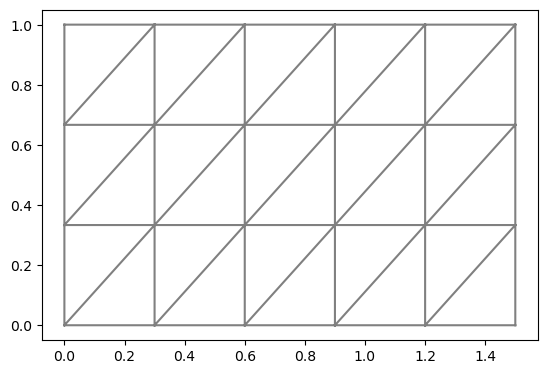

In [3]:
fenics.plot(mesh);

In [4]:
def control_array(control, b=None, sig=None):
    if b is None:
        b = (0, 0)
    if sig is None:
        sig = (0, 0, 0)
    N = int(len(control.array())/5)
    b_array = np.zeros((N, 2)) + b
    sig_array = np.zeros((N, 3)) + sig
    temp_array = np.concatenate([b_array.flatten(), sig_array.flatten()])
    return temp_array

In [33]:
def u_bdy(x, y):
    return ( (x[0] + y[0])**2 + (x[1] + y[1])**2 ) / 20
epsilon = 1.05 * np.sqrt(2) * max([a/(b-1) for a, b in zip(max_xy, (nx, ny))])
eqn = pf.equations.HittingTimes(W, u_bdy, epsilon)

In [34]:
m_data = eqn.control
m_arr = m_data.array().copy()
u_data = eqn.solve(m_data)

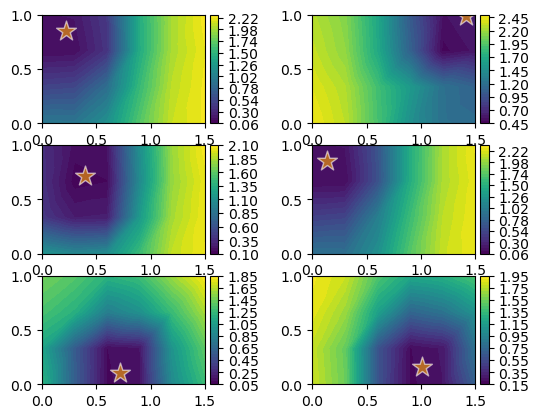

In [35]:
fig, axes = plt.subplots(3, 2)
for ax in axes.flatten():
    xy = random_point()
    u_data.plot(xy, ax=ax)

Let's make a solution that differs a little:

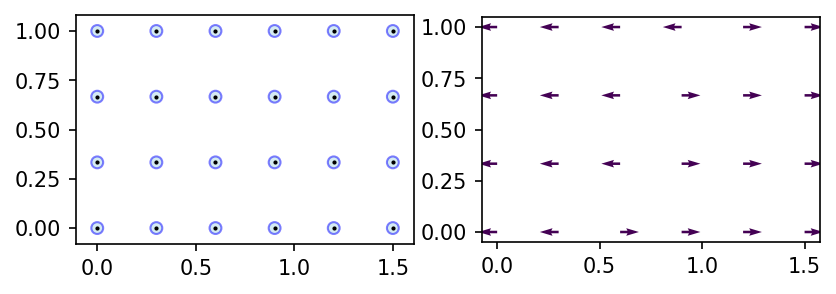

In [36]:
m = eqn.control
bb = np.ones((ny, nx)) * 1
bb[:int(ny/2),:] *= -1
true_m_array = control_array(m, b=np.column_stack([bb.flatten(), np.zeros(nx*ny)]))
m.update(true_m_array)
eqn.plot_control();

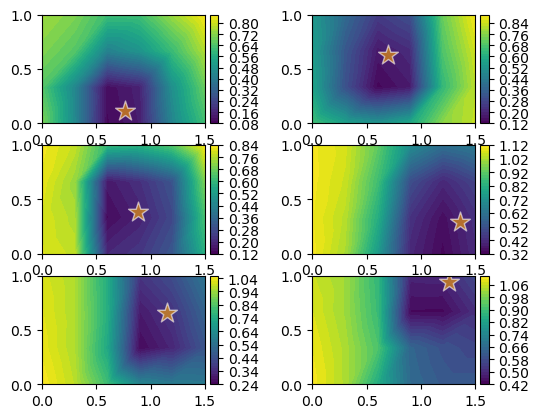

In [37]:
u = eqn.solve(m)
fig, axes = plt.subplots(3, 2)
for ax in axes.flatten():
    xy = random_point()
    u.plot(xy, ax=ax)

Plot the boundary:

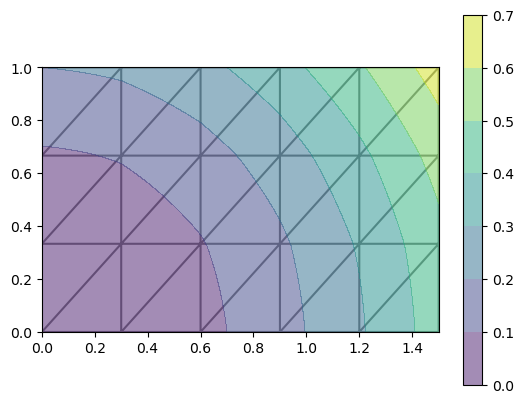

In [38]:
xlims, ylims = (0.0, max_xy[0]), (0.0, max_xy[1])
assert u((xlims[0], ylims[0]), (xlims[1], ylims[1])) > 0

X, Y = np.meshgrid(np.linspace(*xlims, 61), np.linspace(*ylims, 41))
Z = np.array([
    u((x, y), (x,y)) for x, y in zip(X.flatten(), Y.flatten())
]).reshape(X.shape)

fig = fenics.plot(mesh)[0].figure
ax = fig.axes[0]
c = ax.contourf(X, Y, Z, alpha=0.5)
ax.set_aspect(1.0)
fig.colorbar(c);

# The inference problem

In [40]:
reg = {'l2': [1e-12, 1e-12], 'smoothing': [1e-12, 1e-12]}
J = pf.LossFunctional(u, m, reg)
Jhat = pf.ReducedLossFunctional(eqn, J)
print(Jhat(m)) # loss at truth

1.0916666666666668e-11


In [41]:
def Jhat(m):
    u = eqn.solve(m)
    return J(u, m)

In [42]:
# plot slice of loss surface m + h v for h passing through 0 and arbitrary v
hs = np.linspace(-1.0, 2.0, 10)
v = control_array(m, b=(1,1), sig=(0,0,0))
ms = [true_m_array + h * v for h in hs]
Js = []

for mi in ms:
    m.update(mi);
    Js.append(Jhat(m))

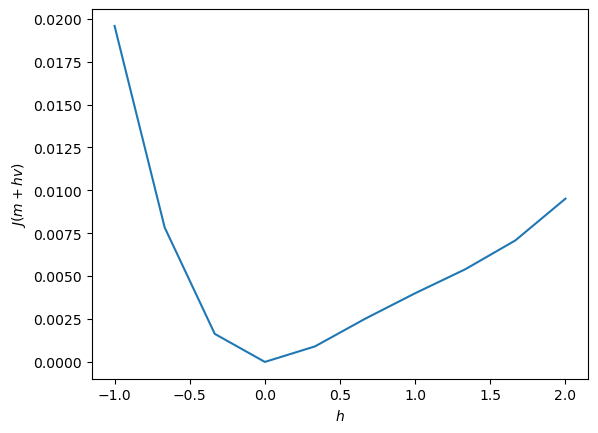

In [43]:
fig, ax = plt.subplots()

ax.plot(hs, Js)
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$J(m + h v)$')
plt.show()

# Inverse problem

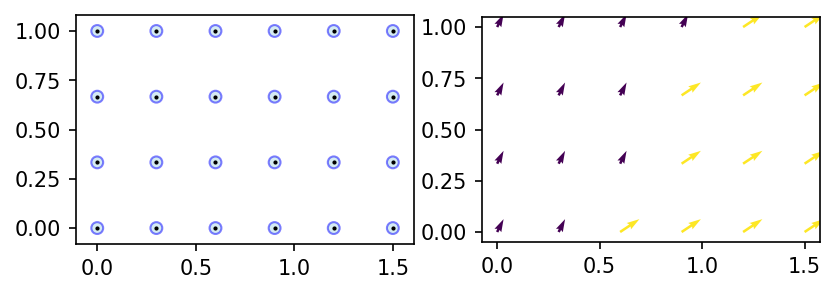

In [44]:
m.update(mi)
eqn.plot_control();

In [45]:
invp = pf.InverseProblem(eqn, J)

allvecs, losses, results = invp.optimize(m, options={"maxiter":5})

loss error l2reg smoothing
0.005508644091317105 0.005508644074414774 6.648058580022397e-12 1.0254272048542833e-11
0.00419980147026115 0.004199801453368077 6.646254839108076e-12 1.0246818568246178e-11
0.003909948369098786 0.003909948352209193 6.64505334423798e-12 1.0244539356584909e-11
0.0037559487876546423 0.003755948770766197 6.64396867658444e-12 1.024447681020752e-11
0.003434206386679598 0.003434206369790108 6.641265671631153e-12 1.0248224542674398e-11


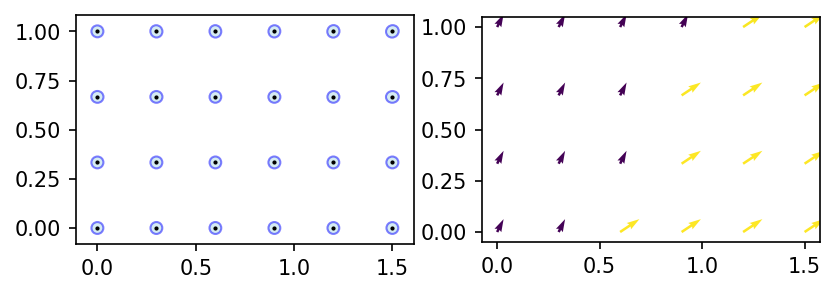

In [46]:
m.update(allvecs[-1])
eqn.plot_control();

In [47]:
allvecs, losses, results = invp.optimize(m, options={"maxiter":5})

loss error l2reg smoothing
0.0033375229663392763 0.0033375229494477902 6.64106798856718e-12 1.0250417953288559e-11
0.0031793119457364702 0.003179311928840182 6.640439933041548e-12 1.0255848417200435e-11
0.0030409558689610088 0.003040955852055649 6.639051730542361e-12 1.0266308370699205e-11
0.002926132869589806 0.0029261328526793027 6.637946648418135e-12 1.0272556714652968e-11
0.0026224019816201826 0.0026224019646961163 6.635254938790277e-12 1.0288811641677635e-11


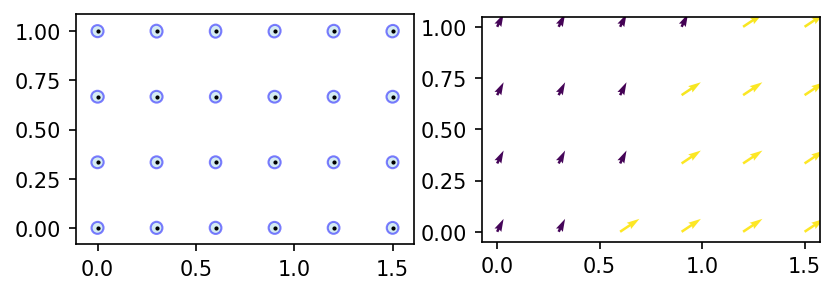

In [48]:
m.update(allvecs[-1])
eqn.plot_control();

In [49]:
allvecs, losses, results = invp.optimize(m, options={"maxiter":25})

loss error l2reg smoothing
0.0024789317019514646 0.0024789316850281303 6.6347633689368855e-12 1.0288570777378558e-11
0.0022647175279404885 0.0022647175110167245 6.633324922751458e-12 1.0290439091464833e-11
0.002201585910649528 0.0022015858937234406 6.632612391551287e-12 1.0293475020065224e-11
0.0020209938345932097 0.0020209938176564534 6.630397001004168e-12 1.0306359279567511e-11
0.0015894338352753419 0.0015894338182896352 6.6239214141114095e-12 1.036178518590822e-11
0.0011423061227626755 0.0011423061056681678 6.6155459154916805e-12 1.0478961610618725e-11
0.0008254589310486834 0.0008254589137536586 6.606538138458474e-12 1.0688486714508688e-11
0.0008013774652208782 0.000801377447850912 6.604275782058091e-12 1.0765690454089743e-11
0.0007814114760407541 0.0007814114586991885 6.605281753727541e-12 1.0736283778019189e-11
0.0007670121396600301 0.0007670121223545003 6.606531221224558e-12 1.0698998686736944e-11
0.0007577725280772039 0.0007577725107749845 6.606305827190043e-12 1.069591367137333

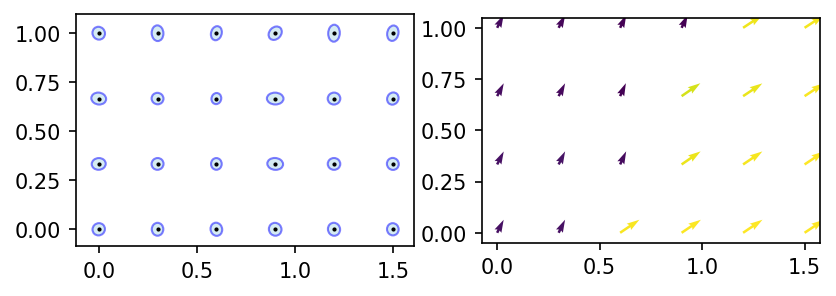

In [50]:
m.update(allvecs[-1])
eqn.plot_control();

In [51]:
allvecs, losses, results = invp.optimize(m, options={"maxiter":25})

loss error l2reg smoothing
0.00047189171272396616 0.0004718916950107462 6.563194425525787e-12 1.115002550809766e-11
0.0004718754972363469 0.00047187547952290274 6.563192130506159e-12 1.115025198511903e-11
0.00047180380354949926 0.00047180378583586147 6.563179657507985e-12 1.1150458172048302e-11
0.00047156159912099176 0.00047156158140726587 6.563150505232917e-12 1.1150575337844903e-11
0.00047113281523047165 0.00047113279751680745 6.563117773233546e-12 1.1150546414733163e-11
0.0004700330909310334 0.0004700330732176374 6.563049326110691e-12 1.1150346713418168e-11
0.0004667523064528126 0.0004667522887403791 6.562852022120263e-12 1.1149581393804334e-11
0.0004586380462215691 0.0004586380285118842 6.562327101326873e-12 1.1147357764484318e-11
0.00044880309928596314 0.0004488030815794228 6.561742477969406e-12 1.1144797884500172e-11
0.0004282495132761882 0.000428249495575601 6.560519650029629e-12 1.1140067520995608e-11
0.00041310957089608186 0.00041310955319928433 6.559634913756607e-12 1.1137162

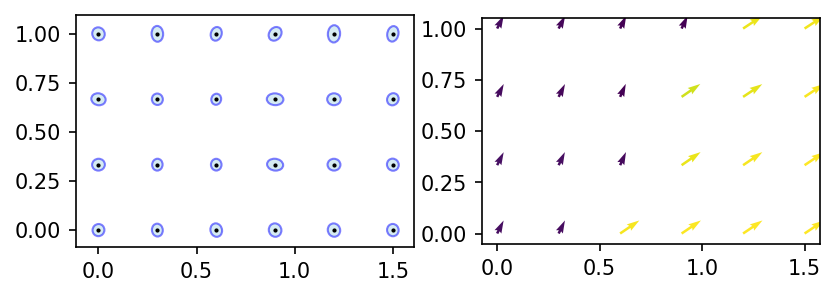

In [52]:
m.update(allvecs[-1])
eqn.plot_control();

In [53]:
allvecs, losses, results = invp.optimize(m, options={"maxiter":100})

loss error l2reg smoothing
0.00036734760966062316 0.0003673475918344099 6.545101366497679e-12 1.1281111907262072e-11
0.00036591122283073847 0.0003659112050037773 6.5449878001481836e-12 1.1281973327434276e-11
0.00036516729283023116 0.0003651672750023124 6.544893347688794e-12 1.1283025409205975e-11
0.0003619908003936855 0.00036199078255968987 6.544366814574179e-12 1.1289628803069803e-11
0.00035730310434844547 0.0003573030865015946 6.543353265699704e-12 1.1303497632829571e-11
0.00035018807029157066 0.0003501880524149426 6.541206283610746e-12 1.1335421785905376e-11
0.0003460585358682925 0.00034605851795373784 6.5387436009887685e-12 1.1375811022895307e-11
0.00034589371971737256 0.0003458937017986204 6.538501274521062e-12 1.1380250838001839e-11
0.0003458586487778121 0.0003458586308576625 6.5384305775266656e-12 1.1381719042833904e-11


In [54]:
results

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.0003458586487778121
        x: [ 1.004e+00  1.992e+00 ...  4.299e-02 -2.813e-02]
      nit: 9
      jac: [ 2.708e-06  6.324e-07 ... -4.087e-06 -9.542e-06]
 hess_inv: [[ 1.003e+00 -8.758e-04 ...  1.002e-02  2.963e-02]
            [-8.758e-04  1.000e+00 ... -2.781e-03 -8.195e-03]
            ...
            [ 1.002e-02 -2.781e-03 ...  1.032e+00  9.357e-02]
            [ 2.963e-02 -8.195e-03 ...  9.357e-02  1.276e+00]]
     nfev: 52
     njev: 40

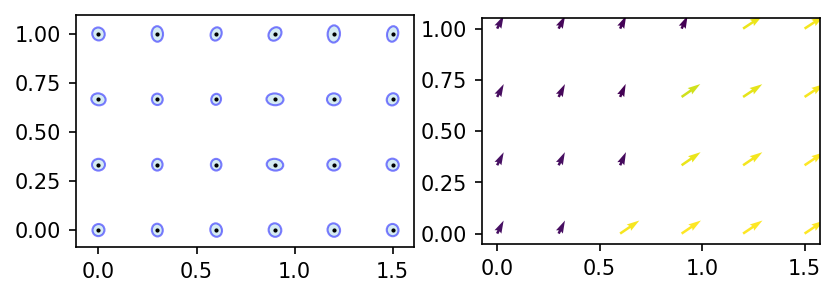

In [55]:
m.update(allvecs[-1])
eqn.plot_control();

# Try Newton-CG?

Works better but slower BUT SEE https://stackoverflow.com/questions/42424444/scipy-optimisation-newton-cg-vs-bfgs-vs-l-bfgs

In [62]:
allvecs, losses, results = invp.optimize(m, method="Newton-CG", options={"maxiter":25})

loss error l2reg smoothing
0.00029827233004614073 0.0002982723092677216 6.318660349350186e-12 1.445975878451663e-11
0.00026848872324432944 0.0002684887020521233 6.297451800004699e-12 1.4894754327002275e-11
0.00023351359078659683 0.0002335135689067626 6.253154528700224e-12 1.5626679717613995e-11
0.0002076278880119644 0.00020762786538983281 6.177448250963693e-12 1.644468332986958e-11
0.00019448972464585615 0.00019448970218347093 6.0735173726674786e-12 1.638886785102814e-11
0.00018636013102178622 0.00018636010855413112 6.072200279812732e-12 1.63954548313818e-11
0.00014943468986171633 0.0001494346680562857 5.691411307762152e-12 1.611401930344494e-11
0.00014845865172114428 0.00014845862991354474 5.691488876674787e-12 1.6116110672449007e-11
0.0001236083373315745 0.0001236083157284225 5.46006669526308e-12 1.6143085288222146e-11
0.00011194227308911891 0.00011194225113398449 5.428773017289922e-12 1.652636139562705e-11
9.827016742158248e-05 9.827014482994864e-05 5.372382423901124e-12 1.721925139

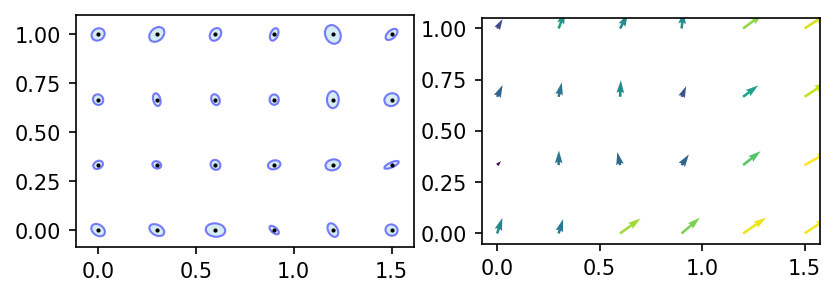

In [63]:
m.update(allvecs[-1])
eqn.plot_control();

In [64]:
results

 message: Warning: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 2.6425948481779593e-05
       x: [ 7.106e-01  1.214e+00 ... -3.451e-02 -6.089e-02]
     nit: 25
     jac: [ 1.974e-06 -7.833e-09 ...  7.490e-07 -2.794e-06]
    nfev: 74
    njev: 4815
    nhev: 0

In [68]:
first_round_m = allvecs[-1]

# Constrain covariances

In [66]:
reg2 = {'l2': [1e-12, 100], 'smoothing': [1e-12, 100]}
J2 = pf.LossFunctional(u, m, reg2)
Jhat2 = pf.ReducedLossFunctional(eqn, J2)
m.update(true_m_array)
print(Jhat2(m)) # loss at truth

1.0916666666666668e-11


In [69]:
m.update(first_round_m)
invp2 = pf.InverseProblem(eqn, J2)

allvecs, losses, results = invp2.optimize(m, method="BFGS", options={"maxiter":25})

loss error l2reg smoothing
138.36961500799495 0.0004020656488230093 3.7746558207105063 134.59455712163563
74.57782142468965 0.0008316516226136983 2.3293709998249605 72.24761877324207
60.3293807344655 0.0024947945467880157 1.7191336283608212 58.607752311557896
54.77618662839954 0.005927994424387323 1.2875766985585222 53.482681935416636
52.01416456827361 0.016688511310669892 0.7954562056167143 51.20201985134622
49.887070419959905 0.027491987850100305 0.6571013712138185 49.20247706089599
47.89496075216668 0.043015147047840756 0.6724262744786988 47.17951933064014
46.98751243709595 0.05297232217339293 0.6462309761286182 46.28830913879394
45.55230710439348 0.052895510290846756 0.6130727069288282 44.8863388871738
43.00004470287138 0.05224747369614227 0.5661800878557649 42.381617141319474
38.70167320131638 0.05276444069037965 0.48834022484049056 38.160568535785515
31.570147793791776 0.04897040945099884 0.44734264587018774 31.073834738470588
26.07255688684115 0.04725534140712562 0.5942690693083

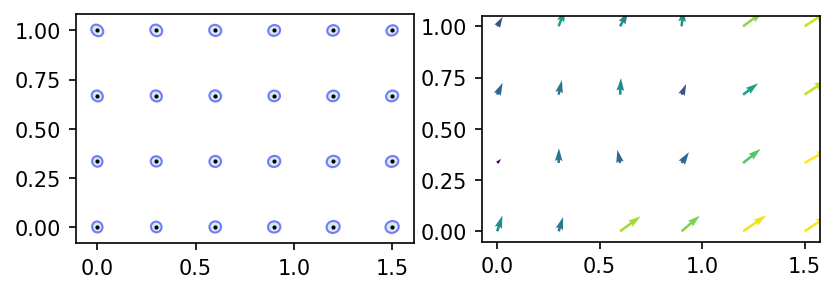

In [70]:
m.update(allvecs[-1])
eqn.plot_control();

loss error l2reg smoothing
4.727199404247035 0.010847945686807709 0.7650866634431933 3.9512647951170337
2.930764290113231 0.010242359611408285 0.5648944484928418 2.355627482008981
1.8262782157627537 0.009790857603557593 0.3342227064043126 1.4822646517548834
1.284347401888905 0.010487830116128931 0.22534073369634952 1.0485188380764265
1.0452604363425535 0.012224866859664762 0.1842511769676729 0.8487843925152158
0.879648227852854 0.01420284555614869 0.16631305187671916 0.6991323304199861
0.8118087296558135 0.017567885012744693 0.14740973616909578 0.6468311084739731
0.7194704230147713 0.019964484277854376 0.13387443196719523 0.5656315067697216
0.682037910632153 0.023327954215876363 0.11537486918753412 0.5433350872287426
0.6454240413083335 0.02341013751597143 0.10002853150659338 0.5219853722857687
0.607530240325776 0.02183164044078679 0.07803754235461381 0.5076610575303754
0.5445257254785126 0.020141092886924745 0.059079765068221386 0.4653048675233665
0.45869441199385297 0.0182520335449415

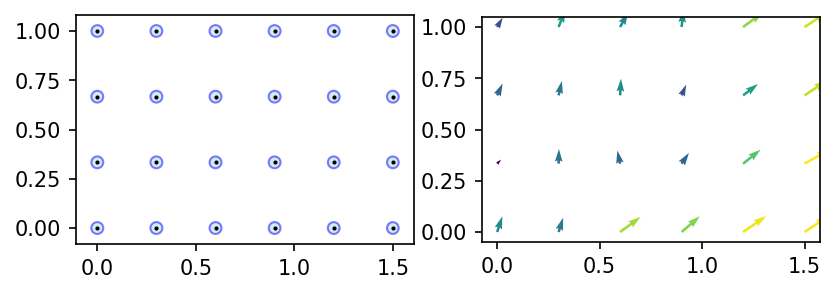

In [71]:
allvecs, losses, results = invp2.optimize(m, method="BFGS", options={"maxiter":25})
m.update(allvecs[-1])
eqn.plot_control();

loss error l2reg smoothing
0.07404899235531065 0.016363671788924 0.004816800609682848 0.052868519956703795
0.05508780258573166 0.01549016160976868 0.0018715041524307971 0.03772613682353218
0.04704631807382059 0.014675665436070753 0.0010764235997296296 0.031294229038020205
0.03838216628066108 0.01414796495152496 0.0008253536796571753 0.023408847649478946
0.035228699170364586 0.013879156017506233 0.0007269454433067394 0.02062259770955161
0.03314418385263722 0.013487750180995864 0.0006925503117612905 0.018963883359880068
0.0322599163582917 0.013226645262658116 0.0007943971465194874 0.018238873949114096
0.031367629710634046 0.013134369746510444 0.0009030786897111816 0.017330181274412423
0.030607996892815736 0.013003216092227161 0.0010996760920836547 0.01650510470850492
0.02989241400686361 0.012810371635990633 0.001228257842740811 0.015853784528132166
0.029155625601665715 0.012624438528407264 0.001270704094400945 0.015260482978857504
0.028073353113970634 0.012493902427928178 0.0012416263899

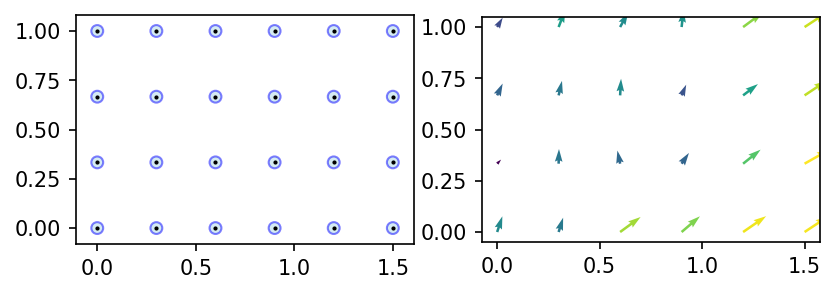

In [72]:
allvecs, losses, results = invp2.optimize(m, method="BFGS", options={"maxiter":25})
m.update(allvecs[-1])
eqn.plot_control();

# L-BFGS-B?  No, it segfaults.